## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

/tmp/ipykernel_573511/593299904.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


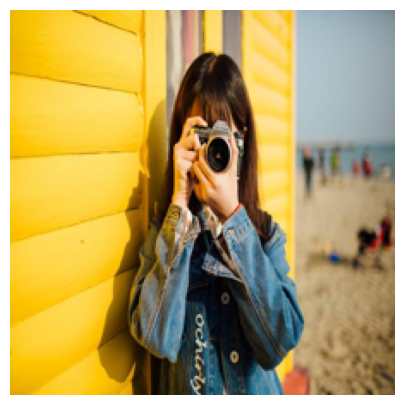

In [8]:
# load an image
img_url = '/home/kang_you/SpikeZIP_transformer_Hybrid_CVPR/demo/pick_photo.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
from spike_quan_layer import MyLayerNorm, set_init_false, LN2BNorm, MyQuan, DyT, MLP_BN, WindowAttention_no_softmax, DyHT, DyHT_ReLU
from spike_quan_wrapper_ICML import myquan_replace, SNNWrapper, remove_softmax, MyBatchNorm1d, add_bn_in_mlp, swap_BN_MLP_MHSA, adjust_LN2BN_Ratio, add_convEmbed
from functools import partial
import torch

chkpt_dir = '/data1/kang_you/SpikeZIP_transformer_resnet1/output/checkpoint-240.pth'
normLayer = partial(DyHT)    
activation = torch.nn.ReLU
# model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
model_mae = models_mae.__dict__["mae_vit_small_patch16"](norm_pix_loss=False, norm_layer=normLayer, act_layer = activation)
remove_softmax(model_mae)
add_bn_in_mlp(model_mae, normLayer)
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model_mae.load_state_dict(checkpoint['model'], strict=False)
print(msg)
print('Model loaded.')


/home/kang_you/anaconda3/envs/SNN/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/kang_you/SpikeZIP_transformer_Hybrid_CVPR/demo/../neuron_cupy/st_bif_ss_cuda.py:29: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
/home/kang_you/SpikeZIP_transformer_Hybrid_CVPR/demo/../neuron_cupy/st_bif_ss_cuda.py:53: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx,
/home/kang_you/SpikeZIP_transformer_Hybrid_CVPR/demo/../spike_quan_layer.py:1953: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


/tmp/ipykernel_573511/593299904.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


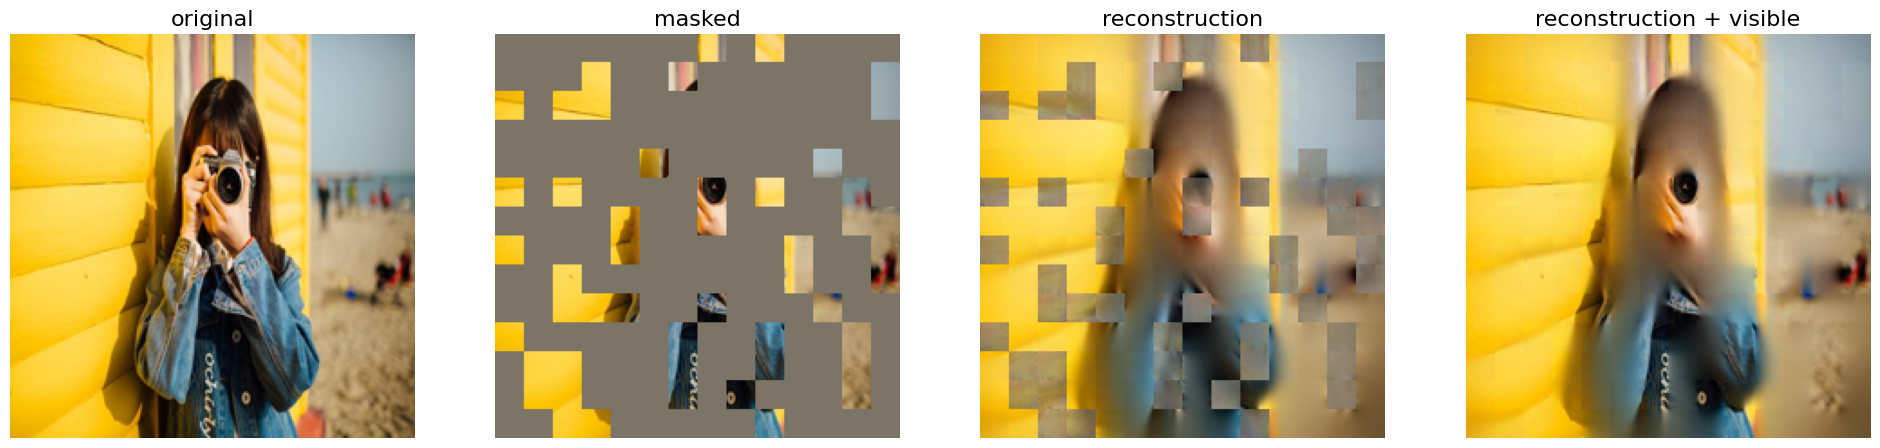

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

MAE with pixel reconstruction:


/tmp/ipykernel_3403864/593299904.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


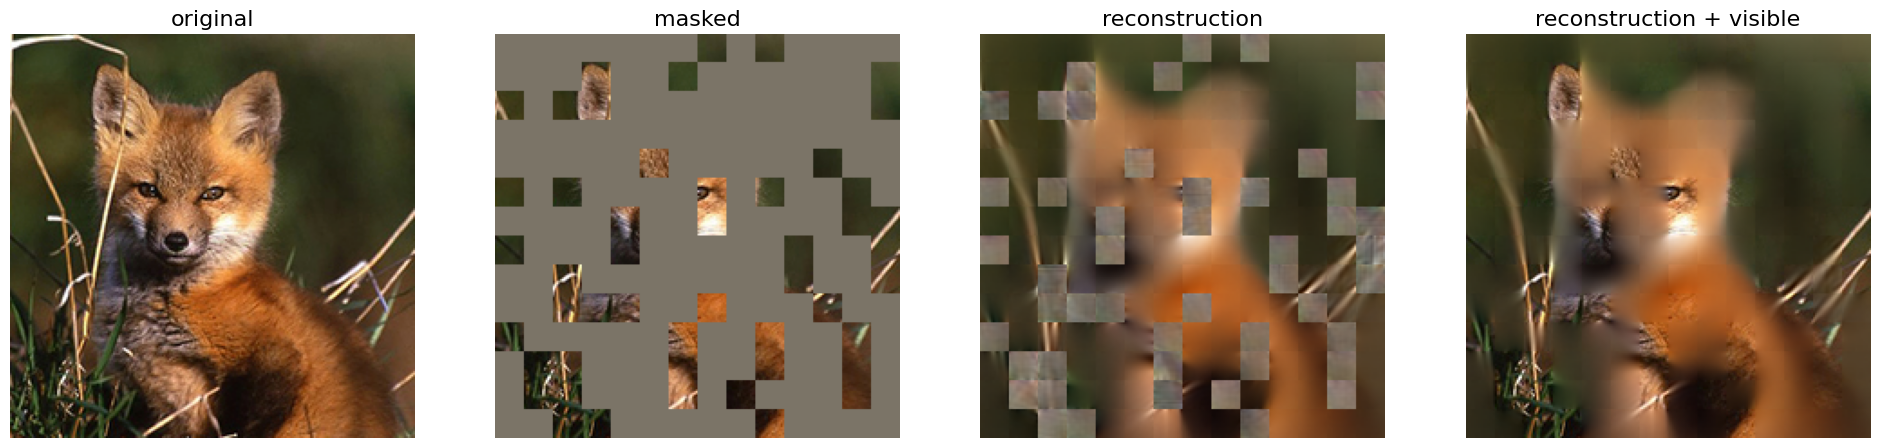

In [17]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [6]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


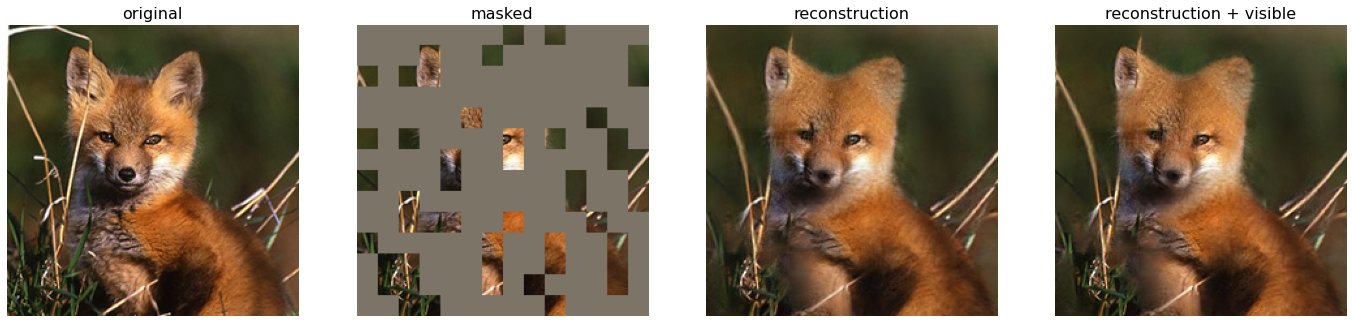

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)